<a href="https://colab.research.google.com/github/MengOonLee/LLM/blob/main/References/LangChain/ipynb/Academy/LangChain/Quickstart/L1_fast_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast Agent - Build a SQL Agent fast!

<img src="https://github.com/MengOonLee/LLM/blob/main/References/LangChain/ipynb/Academy/LangChain/Quickstart/assets/LC_L1_Top.png?raw=true" align="left" width="500">

## Setup

Load and/or check for needed environmental variables

In [ ]:
%%bash
apt-get install zstd
curl -fsSL https://ollama.com/install.sh | sh

In [ ]:
!ollama serve
!ollama pull qwen3:4b

In [ ]:
%%bash
pip install --no-cache-dir -qU \
    langchain langgraph langchain-core langchain-community \
    langchain-huggingface

Initialize LLM model

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")
import dotenv
import langchain_huggingface

_ = dotenv.load_dotenv(dotenv_path=".env", override=True)

# repo_id = "Qwen/Qwen2.5-7B-Instruct"
repo_id = "Qwen/Qwen3-4B-Instruct-2507"
llm_endpoint = langchain_huggingface.HuggingFaceEndpoint(
    huggingfacehub_api_token=os.environ['HF_TOKEN'], provider='auto',
    repo_id=repo_id, temperature=0.1)
llm = langchain_huggingface.ChatHuggingFace(llm=llm_endpoint)

In [ ]:
from langchain_community import utilities

db = utilities.SQLDatabase.from_uri("sqlite:///Chinook.db")

Define the runtime context to provide the agent and tools with access to the database.

In [ ]:
from dataclasses import dataclass

from langchain_community import utilities

# define context structure to support dependency injection
@dataclass
class RuntimeContext:
    db: utilities.SQLDatabase

<b>⚠️ Security Note:</b> This demo does not include a filter on LLM-generated commands. In production, you would want to limit the scope of LLM-generated commands. ⚠️   
This tool will connect to the database. Note the use of `get_runtime` to access the graph **runtime context**.

In [ ]:
from langchain_core.tools import tool
from langgraph import runtime

@tool
def execute_sql(query: str) -> str:
    """Execute a SQLite command and return results."""
    runtimes = runtime.get_runtime(RuntimeContext)
    db = runtimes.context.db

    try:
        return db.run(query)
    except Exception as e:
        return f"Error: {e}"

Add a system prompt to define your agents behavior.

In [ ]:
SYSTEM_PROMPT = """
You are a careful SQLite analyst.

Rules:
- Think step-by-step.
- When you need data, call the tool `execute_sql` with ONE SELECT query.
- Read-only only; no INSERT/UPDATE/DELETE/ALTER/DROP/CREATE/REPLACE/TRUNCATE.
- Limit to 5 rows of output unless the user explicitly asks otherwise.
- If the tool returns 'Error:', revise the SQL and try again.
- Prefer explicit column lists; avoid SELECT *.
"""

Create your agent! Add a model, tools, a prompt, and the runtime access, and go!  You can choose many agents from our [integrations](https://docs.langchain.com/oss/python/integrations/providers) list.

In [ ]:
from langchain import agents

agent = agents.create_agent(
    model=llm,
    tools=[execute_sql],
    system_prompt=SYSTEM_PROMPT,
    context_schema=RuntimeContext
)

Here's a display of the agent ReAct Loop.

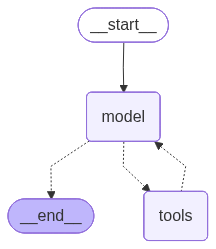

In [ ]:
from IPython import display

display.display(display.Image(agent.get_graph(xray=True).draw_mermaid_png()))

Run some queries. Notice:
- The agent does not have the database schema and will need to discover it independently.
- The agent may make mistakes! By returning error messages, the agent can self-correct its queries.
- Notice you invoke the agent with `agent.stream`.
    - This command and the `pretty_print` display the **messages** that communicate information between the model and the tools.
- Notice the agent doesn't remember the schema between invocations... More on this later!

In [ ]:
question = """
Which table has the largest number of entries?
"""

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values"
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================


Which table has the largest number of entries?

================================== Ai Message ==================================

To determine which table has the largest number of entries, I need to count the number of rows in each table and identify the one with the highest count. 

I will first retrieve the list of tables and then count the rows in each.
Tool Calls:
  execute_sql (chatcmpl-tool-bcaa502e6ffc4e2d9f9c497f2cf7f5d1)
 Call ID: chatcmpl-tool-bcaa502e6ffc4e2d9f9c497f2cf7f5d1
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table';
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================

Now that I

In [ ]:
question = "Which genre on average has the longest tracks?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which genre on average has the longest tracks?
================================== Ai Message ==================================

To determine which genre has the longest tracks on average, I need to:

1. Look at the `tracks` table to get track durations.
2. Join it with the `genres` table to associate each track with its genre.
3. Group by genre and calculate the average duration of tracks for each genre.
4. Order by average duration in descending order and pick the top genre.

I'll start by querying the data.
Tool Calls:
  execute_sql (chatcmpl-tool-16e2ceb5b3a54202a2d65db99f58929c)
 Call ID: chatcmpl-tool-16e2ceb5b3a54202a2d65db99f58929c
  Args:
    query: SELECT g.genre, AVG(t.duration) AS avg_duration FROM tracks t JOIN genres g ON t.genre_id = g.id GROUP BY g.genre ORDER BY avg_duration DESC LIMIT 1
================================= Tool Message =================================
Name: execute_sql

Er

In [ ]:
question = "Please list all of the tables"

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Please list all of the tables
================================== Ai Message ==================================
Tool Calls:
  execute_sql (chatcmpl-tool-550fea2566f647b9b64e8f74cd0411fb)
 Call ID: chatcmpl-tool-550fea2566f647b9b64e8f74cd0411fb
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table';
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================

The available tables in the database are:

- Album  
- Artist  
- Customer  
- Employee  
- Genre  
- Invoice  
- InvoiceLine  
- MediaType  
- Playlist  
- PlaylistTrack  
- Track  

Let me know if you'd like information about any specific table!
